In [2]:
#Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import itertools
import math
from pandas_datareader import data as web
import datetime

sns.set()

In [3]:
# Importação dos Dados #

# Datas escolhidas para análise do período de um ano #
start = datetime.datetime(2020,5,19)
end   = datetime.datetime(2021,5,18)

# Importação dos dados de empresas #
msft = web.DataReader('MSFT', data_source = 'yahoo', start = start, end = end)['Adj Close']
sony = web.DataReader('SONY', data_source = 'yahoo', start = start, end = end)['Adj Close']
ntdoy = web.DataReader('NTDOY', data_source = 'yahoo', start = start, end = end)['Adj Close']
intc = web.DataReader('INTC', data_source = 'yahoo', start = start, end = end)['Adj Close']

# Importação dos dados de criptomoedas #
btc = web.DataReader('BTC-USD', data_source = 'yahoo', start = start, end = end)['Adj Close']
ada = web.DataReader('ADA-USD', data_source = 'yahoo', start = start, end = end)['Adj Close']
eth = web.DataReader('ETH-USD', data_source = 'yahoo', start = start, end = end)['Adj Close']
ltc = web.DataReader('LTC-USD', data_source = 'yahoo', start = start, end = end)['Adj Close']

sp500 = web.DataReader('^GSPC', data_source = 'yahoo', start = start, end = end)['Adj Close']

In [4]:
# Ajuste dos dados #

# Ajuste dos dados de empresas#
comp_stocks = pd.concat([msft, sony, ntdoy, intc], axis=1)
comp_stocks.columns = ['msft', 'sony', 'ntdoy', 'intc']
comp_stocks.reset_index(inplace=True,drop=False)

# Ajuste dos dados de criptomoedas#
crypto_stocks = pd.concat([btc, ada, eth, ltc], axis=1)
crypto_stocks.columns = ['btc', 'ada', 'eth', 'ltc']
crypto_stocks.reset_index(inplace=True,drop=False)

# Junção de ambos os dados #
stocks = comp_stocks.merge(crypto_stocks, on='Date', how='inner' )
stocks = stocks.set_index('Date')
#stocks.drop(['Date'], axis=1, inplace=True)


In [5]:
# Definições para análises #

n_port = 50000 # Número de Portifólios#
N = 252 # Número de dias úteis#

# Definição dos retornos#
returns_simple = ((stocks - stocks.shift(1))/stocks.shift(1)) # Retorno simples#
annualized_returns_simple = np.mean(returns_simple)*N # Retorno anualizado simples#
returns_log = np.log(stocks/stocks.shift(1)) # Retorno logarítmico#
annualized_returns_log = np.mean(returns_log)*N # Retorno anualizado logarítmico#
vol_returns_log = np.std(returns_log)*np.sqrt(N) # Volatilidade do retorno logarítmico
weights = [] # Pesos totais#
np.random.seed(42)

port_expect_ret = [] # Retornos esperados do portifólio#
port_var = [] # Variação esperadas do portifólio#
sharpe_ratio = [] # Sharpe Ratio do portifólio#

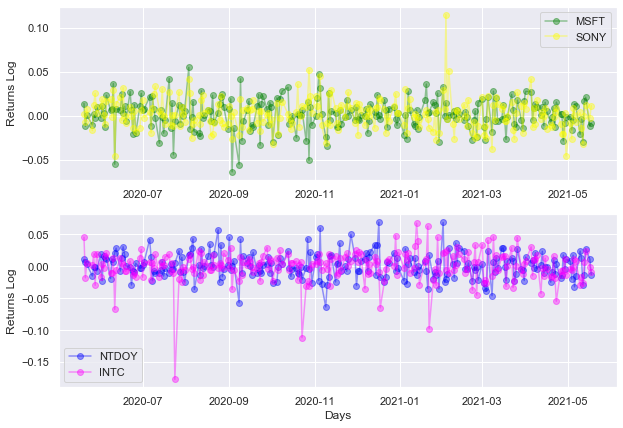

In [23]:
# Retornos Empresas#

plt.figure(1, figsize = (10, 7.0))
plt.subplot(211)
plt.ylabel('Returns Log')
plt.plot(returns_log['msft'], alpha = 0.4, marker = 'o', color="green", label = 'MSFT')
plt.plot(returns_log['sony'], alpha = 0.4, marker = 'o', color="yellow", label = 'SONY')
plt.legend()
plt.subplot(212)
plt.xlabel('Days')
plt.ylabel('Returns Log')
plt.plot(returns_log['ntdoy'], alpha = 0.4, marker = 'o', color="blue", label = 'NTDOY')
plt.plot(returns_log['intc'], alpha = 0.4, marker = 'o', color="fuchsia", label = 'INTC')
plt.legend()
plt.savefig('Ret_Comp')

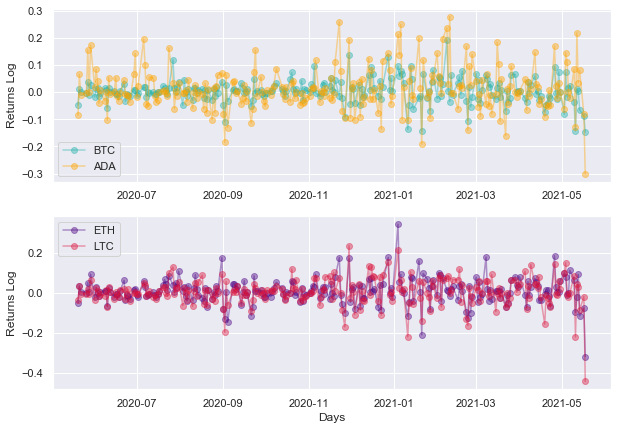

In [24]:
# Retornos Cypto#

plt.figure(1, figsize = (10, 7.0))
plt.subplot(211)
plt.ylabel('Returns Log')
plt.plot(returns_log['btc'], alpha = 0.4, marker = 'o', color="lightseagreen", label = 'BTC')
plt.plot(returns_log['ada'], alpha = 0.4, marker = 'o', color="orange", label = 'ADA')
plt.legend()
plt.subplot(212)
plt.xlabel('Days')
plt.ylabel('Returns Log')
plt.plot(returns_log['eth'], alpha = 0.4, marker = 'o', color="indigo", label = 'ETH')
plt.plot(returns_log['ltc'], alpha = 0.4, marker = 'o', color="crimson", label = 'LTC')
plt.legend()
plt.savefig('Ret_Crypto')

In [8]:
# Portifólio#
for i in range(n_port):
    w = np.array(np.random.random(8))
    w /= np.sum(w) 
    weights.append(w)
    port_expect_ret.append( np.dot(w,annualized_returns_log) )
    port_var.append( np.sqrt(np.dot(w.T, np.dot(returns_log.cov()*N, w))) )
    sharpe_ratio.append( port_expect_ret[i]/port_var[i] )

In [10]:
max_sr = sharpe_ratio.index(max(sharpe_ratio))
optm_return= port_expect_ret[max_sr]
optm_risk = port_var[max_sr]

print('Os pesos do melhor portifólio são:' + '\n' + str(weights[max_sr]))
print('O retorno esperado do portifólio é: ' + str(optm_return) +'\n' + 'e o risco é: ' + str(optm_risk))

Os pesos do melhor portifólio são:
[0.2020066  0.26743101 0.26081205 0.01439592 0.05543298 0.09465879
 0.10309747 0.00216518]
O retorno esperado do portifólio é: 0.9023781496511041
e o risco é: 0.28727934679507705


In [29]:
# Efficient Frontier#

# Constantes para o cálculo
alpha = annualized_returns_log

S = (returns_log.cov()*N) # Matriz de Covariância
S_inv = np.linalg.inv(S)  # Matriz de Precisão

e = np.ones(8)  # Matriz Unitária

M = np.array([[np.dot(e, np.dot(S_inv, e)), np.dot(alpha, np.dot(S_inv, e))], 
              [np.dot(e, np.dot(S_inv, alpha)), np.dot(alpha, np.dot(S_inv, alpha))]])

M_inv = np.linalg.inv(M)


# Calculo da fronteira eficiente
ef_expect_ret = []
ef_var = []
SR = []
for alpha_o in (np.linspace(min(port_expect_ret), max(port_expect_ret), n_port)):
    ef_expect_ret.append(alpha_o)
    M_aux = np.array([1, alpha_o])
    ef_var.append( np.sqrt(np.dot(M_aux, np.dot(M_inv, M_aux))) )
    SR.append(alpha_o/ np.sqrt(np.dot(M_aux, np.dot(M_inv, M_aux))))
    
max_sr_ef = SR.index(max(SR))
optm_return_ef= ef_expect_ret[max_sr_ef]
optm_risk_ef = ef_var[max_sr_ef]


# Matrizes para calcular os melhores Pesos

M_aux3 = np.array([np.dot(S_inv,e), np.dot(S_inv,alpha)])

M_aux2 = np.array([[1],[optm_return_ef]])
alpha_zero = np.dot(M_inv, M_aux2)

w_o = (np.dot(M_aux3.T,alpha_zero)).reshape((8,))

new_weight = []
for i in w_o:
    if i > 0:
        new_weight.append(i)
    else:
        new_weight.append(0)
        
new_weight = new_weight/sum(new_weight)

print('Os pesos do melhor portifólio na fronteira eficiente são:' + 
      '\n' + str(new_weight))
print('O retorno esperado do portifólio na fronteira eficiente é: ' + 
      str(optm_return_ef) +'\n' + 'e o risco é: ' + str(optm_risk_ef))

Os pesos do melhor portifólio na fronteira eficiente são:
[0.17666749 0.30114799 0.12555084 0.         0.10846689 0.10094204
 0.18722475 0.        ]
O retorno esperado do portifólio na fronteira eficiente é: 1.3339908026841436
e o risco é: 0.36310912811046


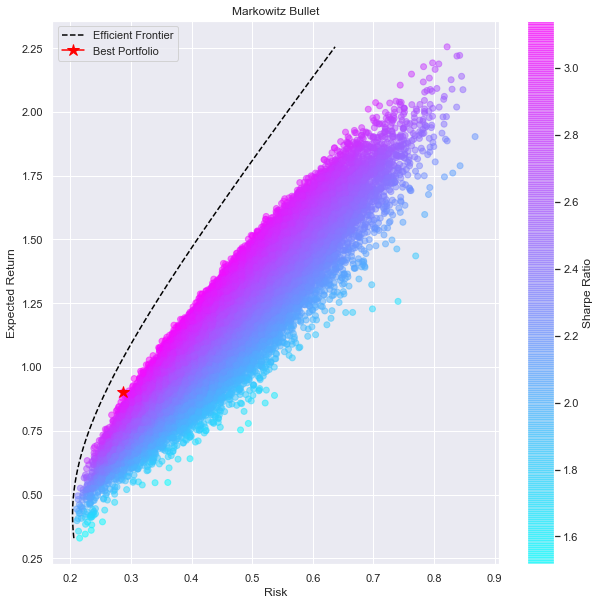

In [32]:
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(port_var, port_expect_ret, c = sharpe_ratio,alpha = 0.5, cmap = 'cool')
plt.colorbar(label = 'Sharpe Ratio')

ax.plot(ef_var, ef_expect_ret, '--', color="black", label = 'Efficient Frontier')
ax.plot(optm_risk, optm_return, color = 'red',marker=  "*", markersize=12, label = 'Best Portfolio')

plt.title("Markowitz Bullet")
plt.ylabel('Expected Return')
plt.xlabel('Risk')
plt.legend()
plt.savefig('Mark_Bullet')
plt.show()


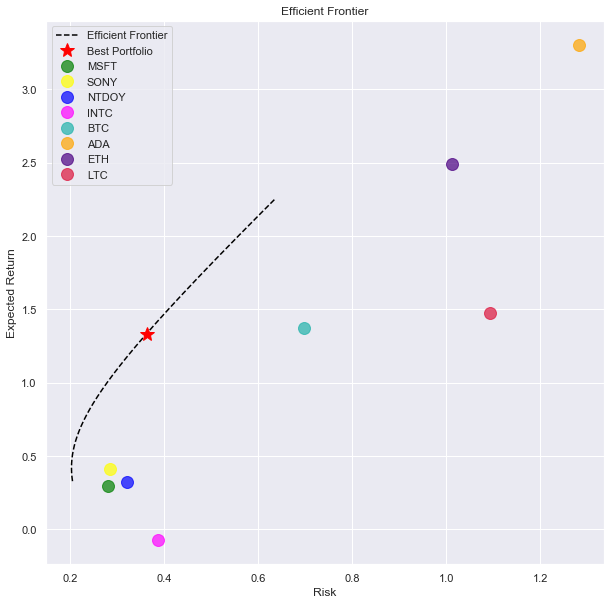

In [33]:
fig, ax = plt.subplots(figsize=(10,10))


ax.plot(ef_var, ef_expect_ret, '--', color="black", label = 'Efficient Frontier')
ax.plot(optm_risk_ef, optm_return_ef, color = 'red',marker=  "*", 
        markersize=15, linestyle = 'None', label = 'Best Portfolio')

ax.plot(vol_returns_log['msft'], annualized_returns_log['msft'], marker=  "o", alpha=0.7, 
        markersize=12, linestyle = 'None',  color="green", label = 'MSFT')
ax.plot(vol_returns_log['sony'], annualized_returns_log['sony'], marker=  "o", alpha=0.7, 
        markersize=12, linestyle = 'None',  color="yellow", label = 'SONY')
ax.plot(vol_returns_log['ntdoy'], annualized_returns_log['ntdoy'], marker=  "o", alpha=0.7, 
        markersize=12, linestyle = 'None',  color="blue", label = 'NTDOY')
ax.plot(vol_returns_log['intc'], annualized_returns_log['intc'], marker=  "o", alpha=0.7, 
        markersize=12, linestyle = 'None',  color="fuchsia", label = 'INTC')
ax.plot(vol_returns_log['btc'], annualized_returns_log['btc'], marker=  "o", alpha=0.7, 
        markersize=12, linestyle = 'None',  color="lightseagreen", label = 'BTC')
ax.plot(vol_returns_log['ada'], annualized_returns_log['ada'], marker=  "o", alpha=0.7, 
        markersize=12, linestyle = 'None',  color="orange", label = 'ADA')
ax.plot(vol_returns_log['eth'], annualized_returns_log['eth'], marker=  "o", alpha=0.7, 
        markersize=12, linestyle = 'None',  color="indigo", label = 'ETH')
ax.plot(vol_returns_log['ltc'], annualized_returns_log['ltc'], marker=  "o", alpha=0.7, 
        markersize=12, linestyle = 'None', color="crimson", label = 'LTC')


plt.title("Efficient Frontier")
plt.ylabel('Expected Return')
plt.xlabel('Risk')
plt.legend()
plt.savefig('Eff_Front')
plt.show()


In [14]:
#TESTE

In [15]:
# CAPM#

In [16]:
def CAPM(stock,market): 
    rf = 0
    stock = stock.to_frame()
    stock.reset_index(inplace=True,drop=False)
    
    market = market.to_frame()
    market.reset_index(inplace=True,drop=False)
    
    data = stock.merge(market, on='Date', how='inner' )
    data.columns = ['Date', 'ativo', "mercado"]
    data.drop(['Date'], axis=1, inplace=True)
    
    r = ((data - data.shift(1))/data.shift(1)) #*100
    #r = (rr - rr.mean())/rr.std()
    #r = np.log(data/data.shift(1))
    beta = (r.cov()/r.iloc[:,[1,]].var()).iloc[0].iloc[1] 
    ri = len(data)
    ri = rf + beta*(r.iloc[:,[1,]] + rf)
    er = rf + beta*(r.iloc[:,[1,]].mean()*252 + rf)
    return(ri,r,beta,er)

# CAPM Comp#
ri_msft_m,r_msft_m,beta_msft, er_msft = CAPM(msft,sp500)
ri_sony_m,r_sony_m,beta_sony, er_sony = CAPM(sony,sp500)
ri_ntdoy_m,r_ntdoy_m,beta_ntdoy, er_ntdoy = CAPM(ntdoy,sp500)
ri_intc_m,r_intc_m,beta_intc, er_intc = CAPM(intc,sp500)

# CAPM Cypto#
ri_btc_m,r_btc_m,beta_btc, er_btc = CAPM(btc,sp500)
ri_ada_m,r_ada_m,beta_ada, er_ada = CAPM(ada,sp500)
ri_eth_m,r_eth_m,beta_eth, er_eth = CAPM(eth,sp500)
ri_ltc_m,r_ltc_m,beta_ltc, er_ltc = CAPM(ltc,sp500)

In [17]:
# Expect Return Portifolio
portfolio_weights = 1/8 * np.ones(8) 
er_list = np.array([float(er_msft), float(er_sony), 
                  float(er_ntdoy),float(er_intc), float(er_btc), float(er_ada), float(er_eth), float(er_ltc)])
ER_portfolio = sum(list(er_list) * portfolio_weights)
ER_portfolio

0.206616916683957

In [18]:
print("O retorno esperado com base no CAPM para MSFT é: ", float(er_msft))
print("O retorno esperado com base no CAPM para SONY é: ", float(er_sony))
print("O retorno esperado com base no CAPM para NTDOY é: ", float(er_ntdoy))
print("O retorno esperado com base no CAPM para INTC é: ", float(er_intc))
print("O retorno esperado com base no CAPM para BTC é: ", float(er_btc))
print("O retorno esperado com base no CAPM para ADA é: ", float(er_ada))
print("O retorno esperado com base no CAPM para ETH é: ", float(er_eth))
print("O retorno esperado com base no CAPM para DOGE é: ", float(er_ltc))

O retorno esperado com base no CAPM para MSFT é:  0.4290310063634
O retorno esperado com base no CAPM para SONY é:  0.22993335407329984
O retorno esperado com base no CAPM para NTDOY é:  0.15269903569366472
O retorno esperado com base no CAPM para INTC é:  0.40419446689777333
O retorno esperado com base no CAPM para BTC é:  0.12174572687885658
O retorno esperado com base no CAPM para ADA é:  0.12840073155103812
O retorno esperado com base no CAPM para ETH é:  0.08011772792560622
O retorno esperado com base no CAPM para DOGE é:  0.10681328408801714


In [19]:
print("O valor de Beta para MSFT é: ", float(beta_msft))
print("O valor de Beta para SONY é: ", float(beta_sony))
print("O valor de Beta para NTDOY é: ", float(beta_ntdoy))
print("O valor de Beta para INTC é: ", float(beta_intc))
print("O valor de Beta para BTC é: ", float(beta_btc))
print("O valor de Beta para ADA é: ", float(beta_ada))
print("O valor de Beta para ETH é: ", float(beta_eth))
print("O valor de Beta para LTC é: ", float(beta_ltc))

O valor de Beta para MSFT é:  1.185515016826673
O valor de Beta para SONY é:  0.6353607083874291
O valor de Beta para NTDOY é:  0.4219438622961839
O valor de Beta para INTC é:  1.11688573347467
O valor de Beta para BTC é:  0.3337625533149557
O valor de Beta para ADA é:  0.3520070651237395
O valor de Beta para ETH é:  0.21964054200318067
O valor de Beta para LTC é:  0.29282567313961033


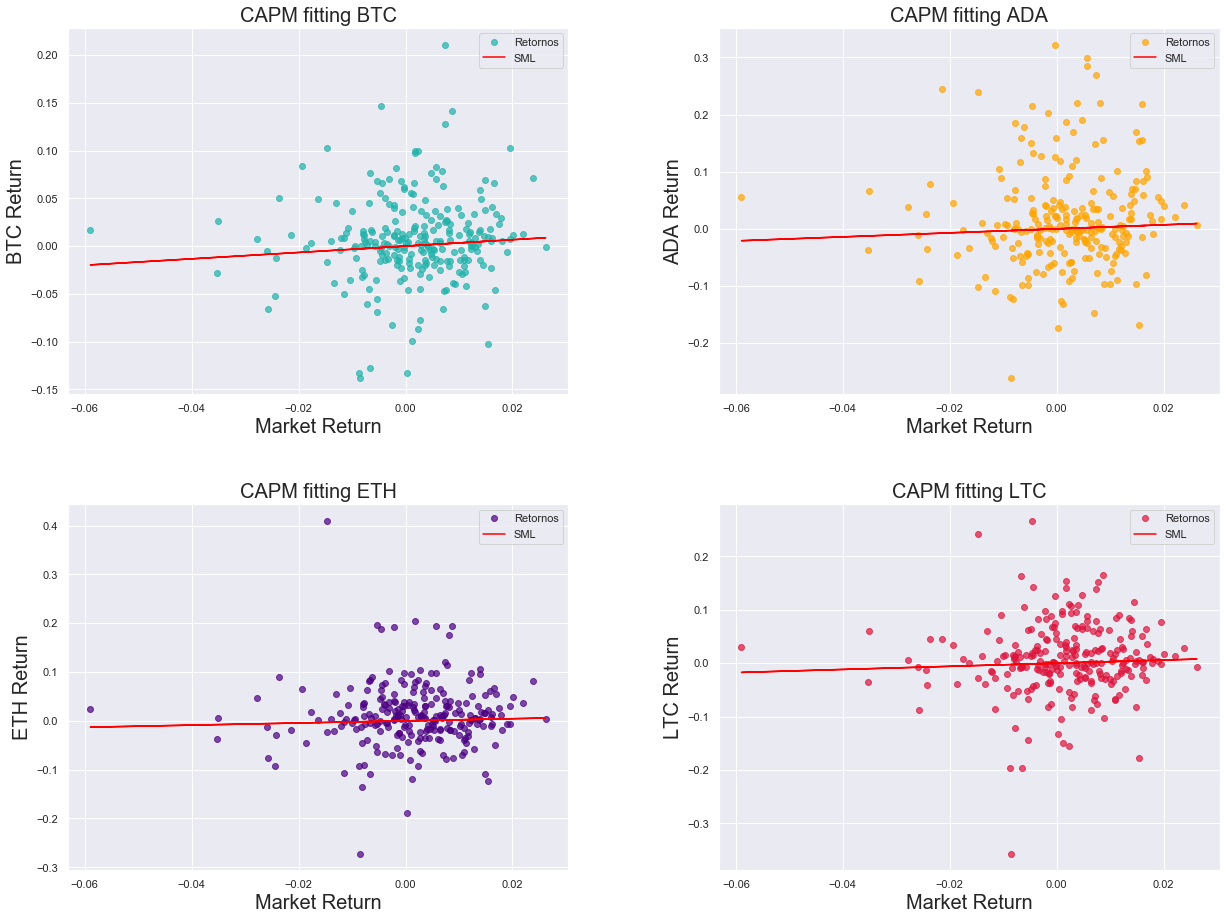

In [36]:
def plot_CAPM_Cypto():
    fig, axs = plt.subplots(2, 2, figsize=(20,13))
    plt.subplots_adjust(left=0.1, 
                        bottom=0.05,
                        right=0.9,
                        top=0.95,
                        wspace=0.3,
                        hspace=0.3)

    axs[0,0].plot(r_btc_m['mercado'],r_btc_m['ativo'], "o", alpha=0.7, color = "lightseagreen", label='Retornos')
    axs[0,0].plot(r_btc_m['mercado'],ri_btc_m['mercado'], color = 'red', label = 'SML')
    axs[0,0].set_ylabel('BTC Return', fontsize=20)
    axs[0,0].set_xlabel('Market Return', fontsize=20)
    axs[0,0].set_title('CAPM fitting BTC', fontsize=20)
    axs[0,0].legend()


    axs[0,1].plot(r_ada_m['mercado'],r_ada_m['ativo'], "o", alpha=0.7, color = "orange", label='Retornos')
    axs[0,1].plot(r_ada_m['mercado'],ri_ada_m['mercado'], color = 'red', label = 'SML')
    axs[0,1].set_ylabel('ADA Return', fontsize=20)
    axs[0,1].set_xlabel('Market Return', fontsize=20)
    axs[0,1].set_title('CAPM fitting ADA', fontsize=20)
    axs[0,1].legend()

    axs[1,0].plot(r_eth_m['mercado'],r_eth_m['ativo'], "o", alpha=0.7, color = "indigo", label='Retornos')
    axs[1,0].plot(r_eth_m['mercado'],ri_eth_m['mercado'], color = 'red', label = 'SML')
    axs[1,0].set_ylabel('ETH Return', fontsize=20)
    axs[1,0].set_xlabel('Market Return', fontsize=20)
    axs[1,0].set_title('CAPM fitting ETH', fontsize=20)
    axs[1,0].legend()

    axs[1,1].plot(r_ltc_m['mercado'],r_ltc_m['ativo'], "o", alpha=0.7, color = "crimson", label='Retornos')
    axs[1,1].plot(r_ltc_m['mercado'],ri_ltc_m['mercado'], color = 'red', label = 'SML')
    axs[1,1].set_ylabel('LTC Return', fontsize=20)
    axs[1,1].set_xlabel('Market Return', fontsize=20)
    axs[1,1].set_title('CAPM fitting LTC', fontsize=20)
    axs[1,1].legend()
    plt.savefig('CAPM_Comp1')

plot_CAPM_Cypto()

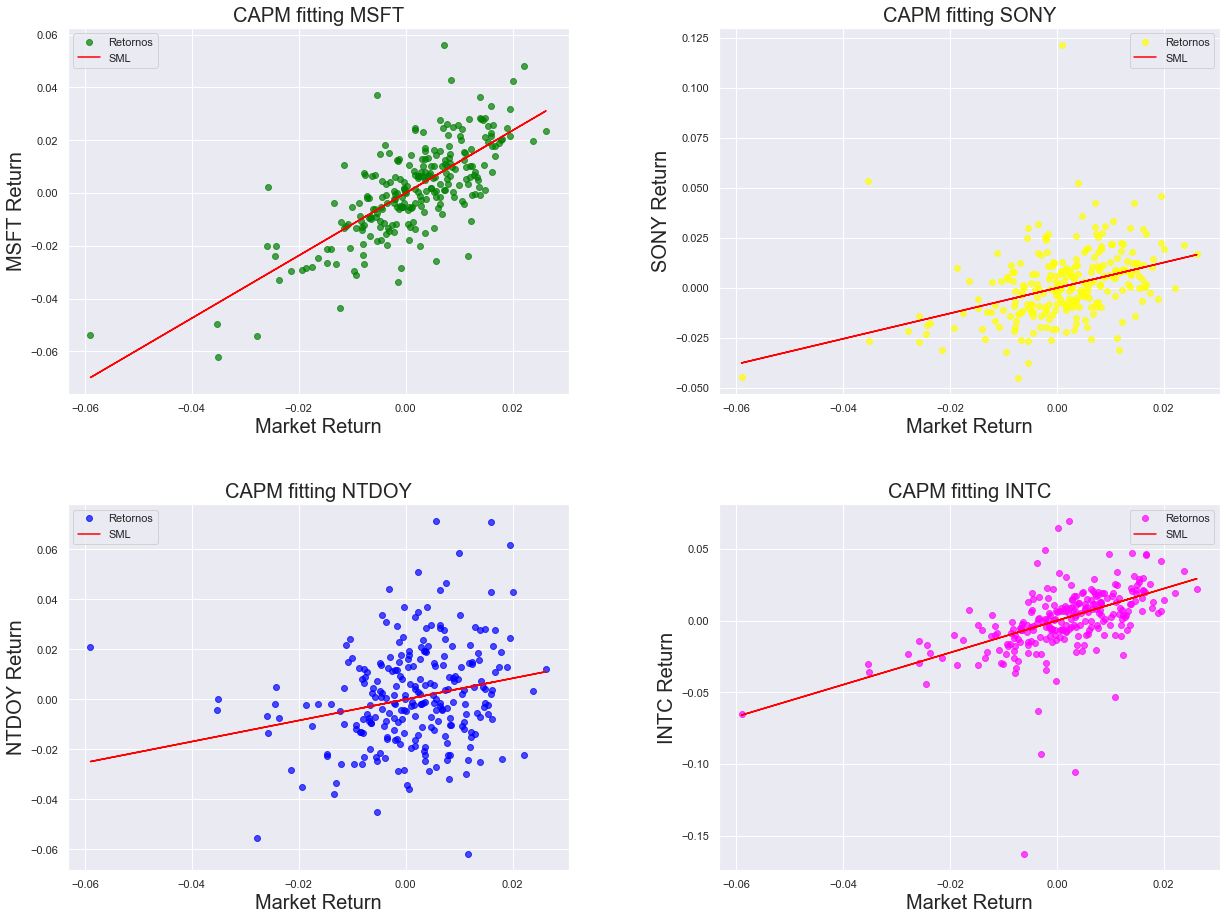

In [37]:
def plot_CAPM_Comp():
    fig, axs = plt.subplots(2, 2, figsize=(20,13))
    plt.subplots_adjust(left=0.1, 
                        bottom=0.05,
                        right=0.9,
                        top=0.95,
                        wspace=0.3,
                        hspace=0.3)

    axs[0,0].plot(r_msft_m['mercado'],r_msft_m['ativo'], "o", alpha=0.7, color = "green", label='Retornos')
    axs[0,0].plot(r_msft_m['mercado'],ri_msft_m['mercado'], color = 'red', label = 'SML')
    axs[0,0].set_ylabel('MSFT Return', fontsize=20)
    axs[0,0].set_xlabel('Market Return', fontsize=20)
    axs[0,0].set_title('CAPM fitting MSFT', fontsize=20)
    axs[0,0].legend()


    axs[0,1].plot(r_sony_m['mercado'],r_sony_m['ativo'], "o", alpha=0.7, color = "yellow", label='Retornos')
    axs[0,1].plot(r_sony_m['mercado'],ri_sony_m['mercado'], color = 'red', label = 'SML')
    axs[0,1].set_ylabel('SONY Return', fontsize=20)
    axs[0,1].set_xlabel('Market Return', fontsize=20)
    axs[0,1].set_title('CAPM fitting SONY', fontsize=20)
    axs[0,1].legend()

    axs[1,0].plot(r_ntdoy_m['mercado'],r_ntdoy_m['ativo'], "o", alpha=0.7, color = "blue", label='Retornos')
    axs[1,0].plot(r_ntdoy_m['mercado'],ri_ntdoy_m['mercado'], color = 'red', label = 'SML')
    axs[1,0].set_ylabel('NTDOY Return', fontsize=20)
    axs[1,0].set_xlabel('Market Return', fontsize=20)
    axs[1,0].set_title('CAPM fitting NTDOY', fontsize=20)
    axs[1,0].legend()

    axs[1,1].plot(r_intc_m['mercado'],r_intc_m['ativo'], "o", alpha=0.7, color = "fuchsia", label='Retornos')
    axs[1,1].plot(r_intc_m['mercado'],ri_intc_m['mercado'], color = 'red', label = 'SML')
    axs[1,1].set_ylabel('INTC Return', fontsize=20)
    axs[1,1].set_xlabel('Market Return', fontsize=20)
    axs[1,1].set_title('CAPM fitting INTC', fontsize=20)
    axs[1,1].legend()
    plt.savefig('CAPM_Cypto1')

plot_CAPM_Comp()